In [ ]:
!pip install moviepy
!pip install autokeras
!pip install --upgrade keras_nlp
# Fix for the plotting in Kaggle
!pip install pydot
!apt-get install -y graphviz
!pip install graphviz

  Using cached autokeras-2.0.0-py3-none-any.whl (122 kB)
  Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import os
import glob
import cv2
import shutil
import torchaudio
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import *
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
import autokeras as ak
from keras.models import save_model
from moviepy.video.io.VideoFileClip import VideoFileClip
import librosa
from sklearn.model_selection import train_test_split
import h5py
import shutil

In [ ]:
source_dir_real = '/content/drive/MyDrive/celabdfv2dataset.csv/Celeb-real'
source_dir_fake = '/content/drive/MyDrive/celabdfv2dataset.csv/Celeb-synthesis'
destination_dir_real = '/kaggle/working/dataset/Real'
destination_dir_fake = '/kaggle/working/dataset/Fake'
dataset_root = '/content/drive/MyDrive/celabdfv2dataset.csv'

In [ ]:
#shutil.rmtree("/kaggle/working")

In [ ]:
# Create the destination directory for Real and Fake videos
os.makedirs(destination_dir_real, exist_ok=True)
os.makedirs(destination_dir_fake, exist_ok=True)

# Get the list of REAL videos
file_list_real = os.listdir(source_dir_real)

# Copy files from the source to the destination
for filename in file_list_real[:100]:
    source_file = os.path.join(source_dir_real, filename)
    destination_file = os.path.join(destination_dir_real, filename)
    shutil.copy(source_file, destination_file)

# Get the list of FAKE videos
file_list_fake = os.listdir(source_dir_fake)
# Copy the files from the source to the destination
for filename in file_list_fake[:100]:
    source_file = os.path.join(source_dir_fake, filename)
    destination_file = os.path.join(destination_dir_fake, filename)
    shutil.copy(source_file, destination_file)

print("Files copied successfully.")

Files copied successfully.


In [ ]:
def extract_audio_files():
    real_video_files = glob.glob(os.path.join(dataset_root, "Real", "*.mp4"))
    fake_video_files = glob.glob(os.path.join(dataset_root, "Fake", "*.mp4"))
    all_video_files = real_video_files + fake_video_files
    for video_file in all_video_files:
        video_clip = VideoFileClip(video_file)
        audio_clip = video_clip.audio
        output_audio_path = os.path.splitext(video_file)[0] + ".wav"
        audio_clip.write_audiofile(output_audio_path, codec='pcm_s16le')

In [ ]:
def extract_video_frames(video_path, image_size, num_frames=10):
    video_capture = cv2.VideoCapture(video_path)
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

    frames = []

    for frame_num in range(min(frame_count, num_frames)):
        ret, frame = video_capture.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, image_size)
        frames.append(frame)

    return frames

In [ ]:
dataset_root = '/content/drive/MyDrive/celabdfv2dataset.csv'
real_video_paths = glob.glob(os.path.join(dataset_root, "Celeb-real", "*.mp4"))
fake_video_paths = glob.glob(os.path.join(dataset_root, "Celeb-synthesis", "*.mp4"))

image_size = (64, 64)
num_samples = 100
X_images_real = [extract_video_frames(video_path, image_size) for video_path in real_video_paths[:num_samples]]
X_images_fake = [extract_video_frames(video_path, image_size) for video_path in fake_video_paths[:num_samples]]
# Convert to numpy arrays
X_images_real = np.array(X_images_real)
X_images_fake = np.array(X_images_fake)

# Concatenate the data
X_images = np.concatenate((X_images_real, X_images_fake), axis=0)

# Create the labels
y_real = np.zeros(num_samples)
y_fake = np.ones(num_samples)
y = np.concatenate((y_real, y_fake), axis=0)

# Split the data to train and test sets
X_images_train, X_images_test, y_train, y_test = train_test_split(
    X_images, y, test_size=0.2, random_state=42
    )

print("X_images_train shape:", X_images_train.shape)
print("X_images_test shape:", X_images_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_images_train shape: (160, 10, 64, 64, 3)
X_images_test shape: (40, 10, 64, 64, 3)
y_train shape: (160,)
y_test shape: (40,)


In [ ]:
# Save the data in a HDF5 file for faster processing and beter RAM utilization
h5_file = h5py.File('/kaggle/working/dataset/data.h5', 'w')

h5_file.create_dataset('X_images_train', data=X_images_train)
h5_file.create_dataset('X_images_test', data=X_images_test)
h5_file.create_dataset('y_train', data=y_train)
h5_file.create_dataset('y_test', data=y_test)

# Close the HDF5 file
h5_file.close()

In [ ]:
del X_images_train
del X_images_test
del y_train
del y_test

In [ ]:
import gc
gc.collect()

20

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12288)               │       1,585,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,594,176 (6.08 MB)

 Trainable params: 1,594,176 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64, 64, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64, 64, 1)           │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,833 (34.50 KB)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 64, 64, 3)           │       1,594,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, 64, 64, 1)           │           8,833 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,603,009 (6.11 MB)

 Trainable params: 1,594,176 (6.08 MB)

 Non-trainable params: 8,833 (34.50 KB)

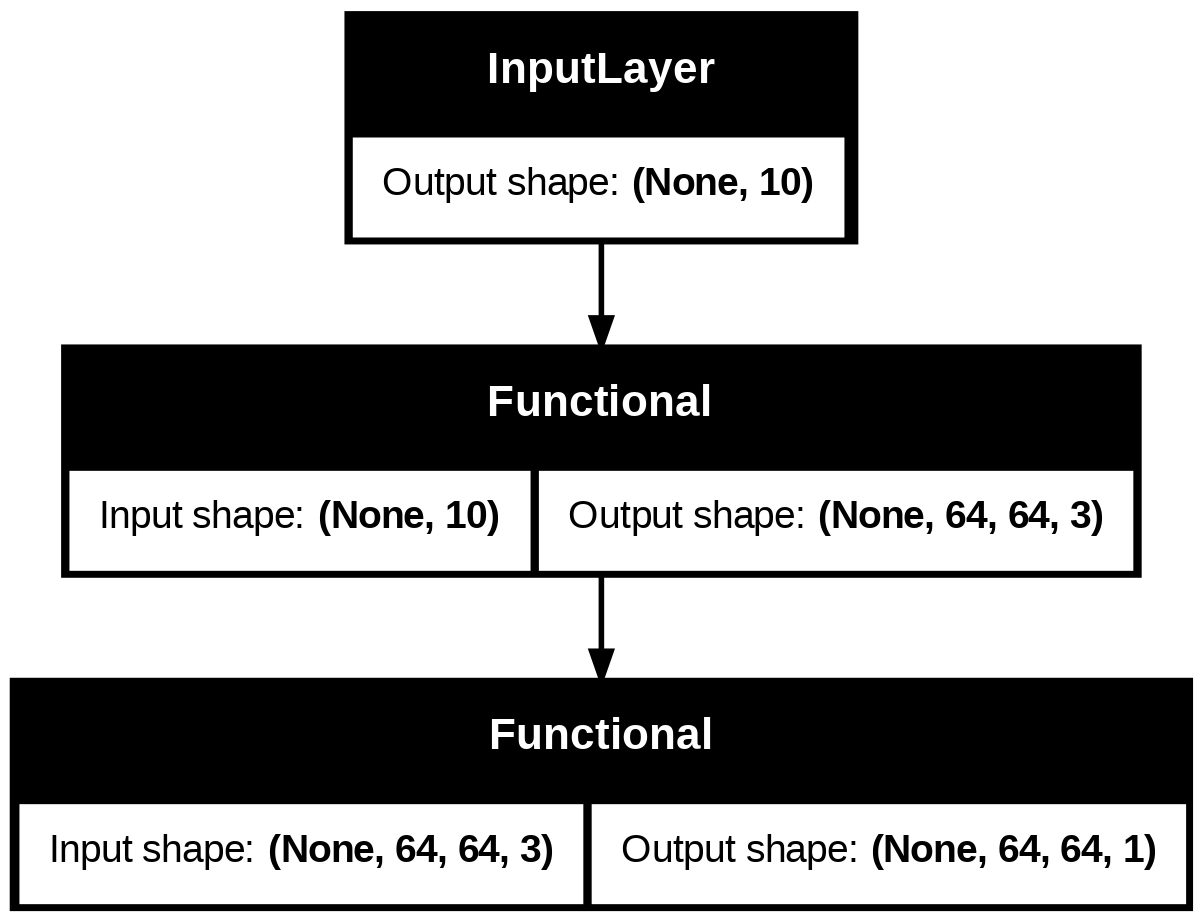

In [ ]:
latent_dim = 10
image_shape = (64, 64, 3)
output_shape = (64, 64, 3)

# Build the Generator model
def build_generator(latent_dim, output_shape):
    generator_input = Input(shape=(latent_dim,))
    x = Dense(64)(generator_input)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = LeakyReLU()(x)

    # Calculate the number of units in the Dense layer for the generator output
    num_units = output_shape[0] * output_shape[1] * output_shape[2]

    # Generator output with a Dense layer and reshape
    generated_data = Dense(num_units, activation='tanh')(x)
    generated_data = Reshape(output_shape)(generated_data)

    generator = Model(generator_input, generated_data)
    return generator

# Build the Discriminator model
def build_discriminator(input_shape):
    discriminator_input = Input(shape=input_shape)
    x = Dense(128)(discriminator_input)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    validity = Dense(1, activation='sigmoid')(x)
    discriminator = Model(discriminator_input, validity)
    return discriminator

# Build the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    generated_data = generator(gan_input)
    gan_output = discriminator(generated_data)
    gan = Model(gan_input, gan_output)
    return gan

generator = build_generator(latent_dim, output_shape)
discriminator = build_discriminator(output_shape)
gan = build_gan(generator, discriminator)

# Print the model summaries
generator.summary()
discriminator.summary()
gan.summary()

# Plot the model architectures
plot_model(generator, show_shapes=True, to_file="generator.png")
plot_model(discriminator, show_shapes=True, to_file="discriminator.png")
plot_model(gan, show_shapes=True, to_file="gan.png")

In [ ]:
def multimodal_fusion(images, num_modalities):
    num_samples, num_frames, height, width, channels = images.shape

    # Create additional modalities by converting images to grayscale
    additional_modalities = []
    for i in range(1, num_modalities):
        modified_images = []
        for frame in range(num_frames):
            grayscale_frame = np.mean(images[:, frame], axis=-1, keepdims=True)
            modified_images.append(grayscale_frame)
        additional_modalities.append(np.array(modified_images))

    # Tile the additional modalities to match the number of frames
    tiled_modalities = [modalities[:, np.newaxis] for modalities in additional_modalities]
    tiled_modalities = [np.tile(modalities, (1, num_frames, 1, 1, 1)) for modalities in tiled_modalities]

    # Concatenate the original images and additional modalities along the channel axis
    fused_data = np.concatenate((images, *tiled_modalities), axis=-1)
    return fused_data

In [ ]:
batch_size = 40
num_modalities = 1 #Add GrayScale with RGB modality

# Load the data from the HDF5 file
h5_file = h5py.File('/kaggle/working/dataset/data.h5', 'r')
num_samples = len(h5_file['X_images_train'])
y_train = h5_file['y_train'][:]

multimodal_data = []

for batch_start in range(0, num_samples, batch_size):
    batch_end = min(batch_start + batch_size, num_samples)
    batch_X_images_train = h5_file['X_images_train'][batch_start:batch_end]
    #batch_X_images_test = h5_file['X_images_test'][batch_start:batch_end]

    # Perform multimodal fusion on the current batch
    fused_batch_X_train = multimodal_fusion(batch_X_images_train, num_modalities)
    #fused_batch_X_test = multimodal_fusion(batch_X_images_test, num_modalities)
    multimodal_data.append(fused_batch_X_train)
    print("Fused batch X_train shape:", fused_batch_X_train.shape)
    #print("Fused batch X_test shape:", fused_batch_X_test.shape)

h5_file.close()

Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)


In [ ]:
# Stack the multimodal data
fused_X_train = np.vstack(multimodal_data)

# Get the dimensions from the shape of fused_X_train
num_samples, num_frames, height, width, channels = fused_X_train.shape

# Reshape the data to match AutoKeras expected format
reshaped_X_train = fused_X_train.reshape((-1, height, width, channels))

# Reshape again to treat each frame as a separate sample
reshaped_X_train = reshaped_X_train.reshape((-1, height, width, channels))

# Reshape y_train to match the new number of samples
reshaped_y_train = np.repeat(y_train, num_frames, axis=0)

print("reshaped_X_train shape:", reshaped_X_train.shape)
print("reshaped_y_train shape:", reshaped_y_train.shape)

X_train, X_val, y_train, y_val = train_test_split(reshaped_X_train, reshaped_y_train, test_size=0.2, random_state=42)

# Create the image-based AutoKeras model
search = ak.ImageClassifier(max_trials=2)

# Train the NAS model
history = search.fit(reshaped_X_train, reshaped_y_train, epochs=4, validation_data=(X_val, y_val))
print(history.history.keys())

# Export the best model architecture
best_model = search.export_model()

Trial 2 Complete [01h 25m 10s]
val_loss: 0.9184598922729492

Best val_loss So Far: 0.004065292421728373
Total elapsed time: 01h 27m 10s
Epoch 1/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 465ms/step - accuracy: 0.5850 - loss: 0.8767 - val_accuracy: 0.8500 - val_loss: 0.3437
Epoch 2/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 506ms/step - accuracy: 0.9002 - loss: 0.2332 - val_accuracy: 0.9812 - val_loss: 0.0623
Epoch 3/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 459ms/step - accuracy: 0.9478 - loss: 0.1120 - val_accuracy: 0.9750 - val_loss: 0.0844
Epoch 4/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 501ms/step - accuracy: 0.9950 - loss: 0.0503 - val_accuracy: 1.0000 - val_loss: 0.0064
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


  saveable.load_own_variables(weights_store.get(inner_path))



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32 (CastToFloat32)      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          57,601 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Activation)   │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,000 (300.79 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 7 (32.00 B)

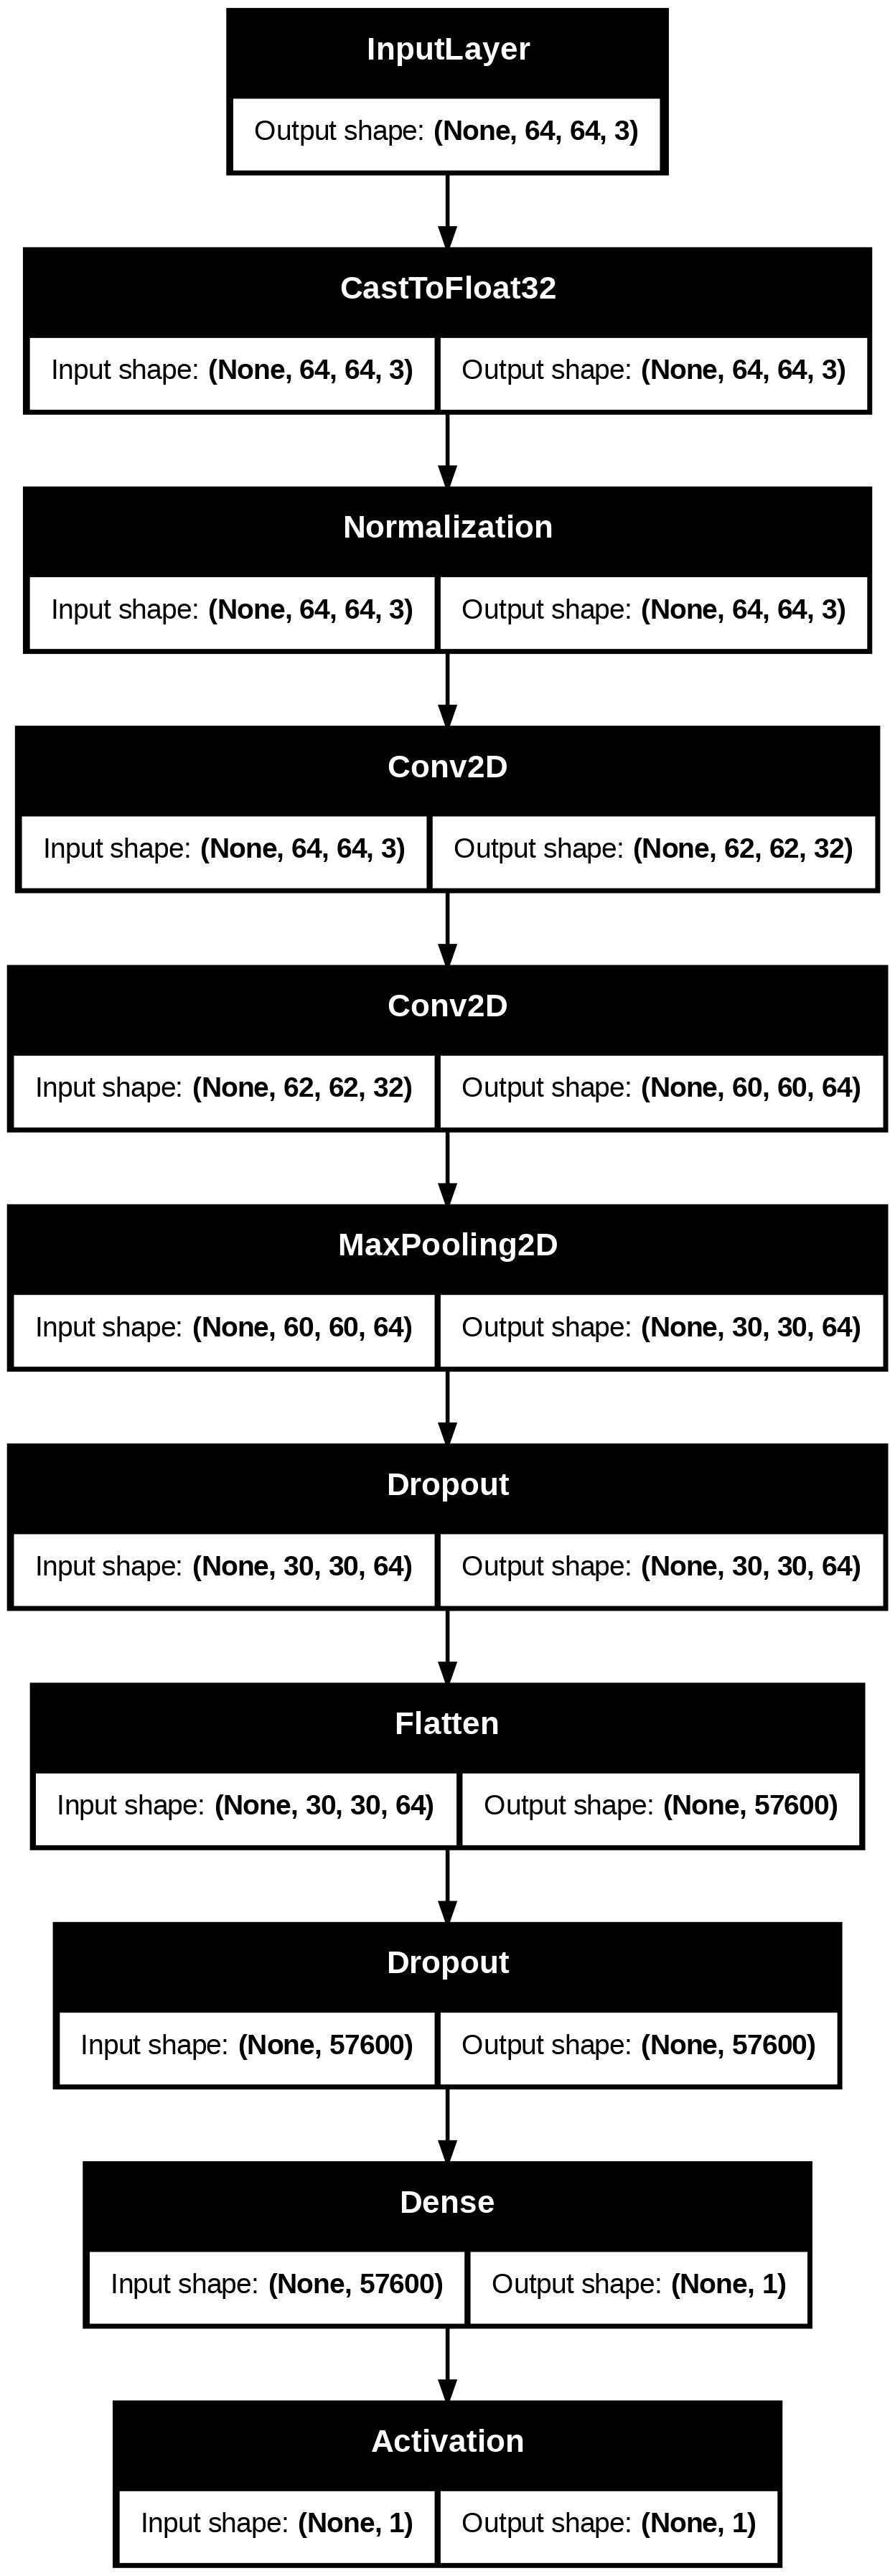

In [ ]:
# Save the model
save_model(best_model, '/kaggle/working/best_model.h5')

# Print the model summary
best_model.summary()

# Plot the model architecture
plot_model(best_model, show_shapes=True, to_file="best_model.png")

In [ ]:
# Compile the best model
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(X_val, y_val)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 496ms/step - accuracy: 0.9990 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 483ms/step - accuracy: 1.0000 - loss: 6.4040e-04 - val_accuracy: 1.0000 - val_loss: 3.5476e-04
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - accuracy: 1.0000 - loss: 2.3601e-04 - val_accuracy: 1.0000 - val_loss: 5.3302e-05
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step - accuracy: 1.0000 - loss: 3.6883e-05 - val_accuracy: 1.0000 - val_loss: 2.9725e-05
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 501ms/step - accuracy: 1.0000 - loss: 2.4063e-05 - val_accuracy: 1.0000 - val_loss: 1.5493e-05
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 499ms/step - accuracy: 1.0000 - loss: 1.9450e-05 - val_accuracy: 1.0000 - val_loss: 1.2187e-05
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 1.0000 - loss: 1.2520e-05 - val_accuracy: 1.0000 - val_loss: 9.4149e-06
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 606ms/s

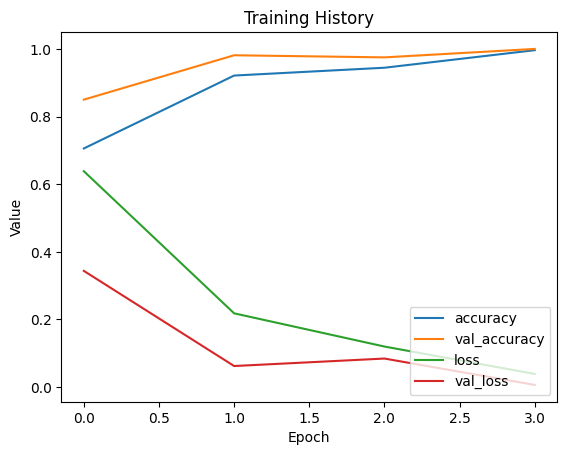

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.title('Training History')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


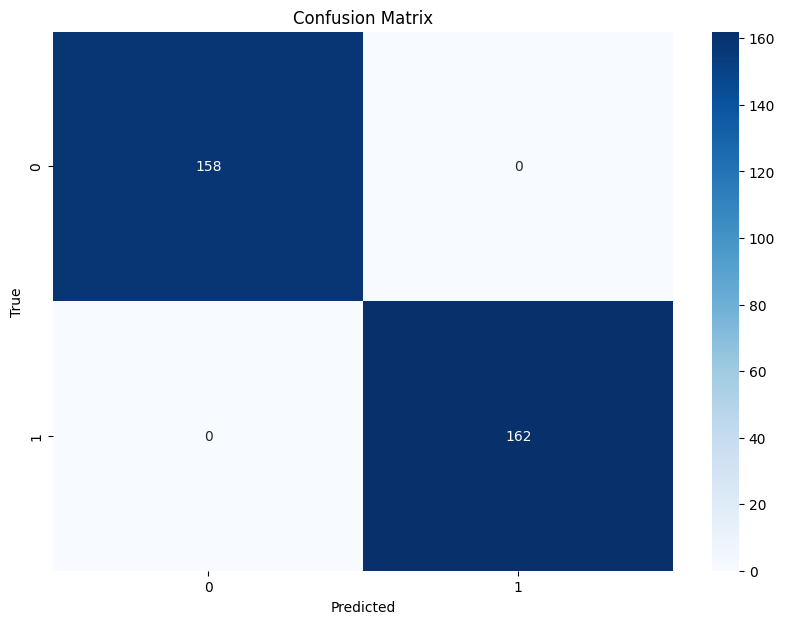

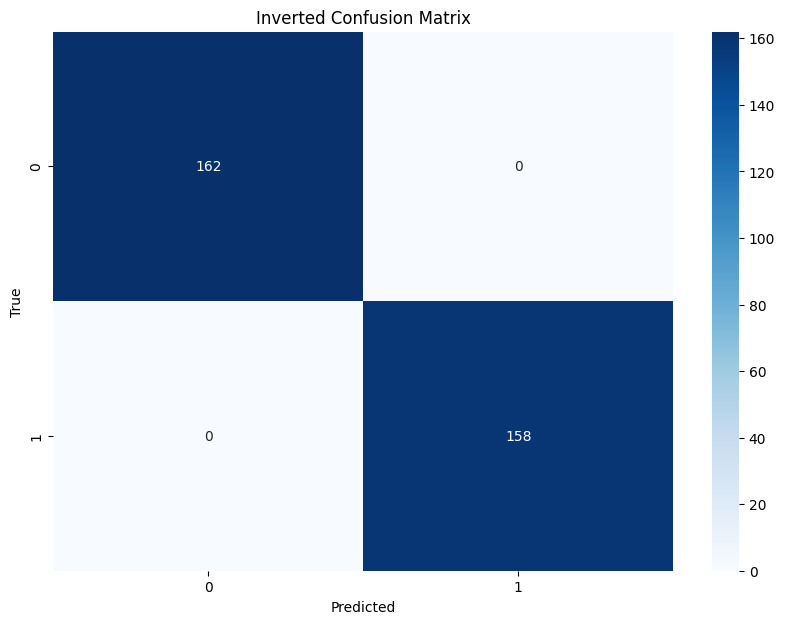

      Metric  Score
0   Accuracy    1.0
1  Precision    1.0
2     Recall    1.0
3   F1 Score    1.0


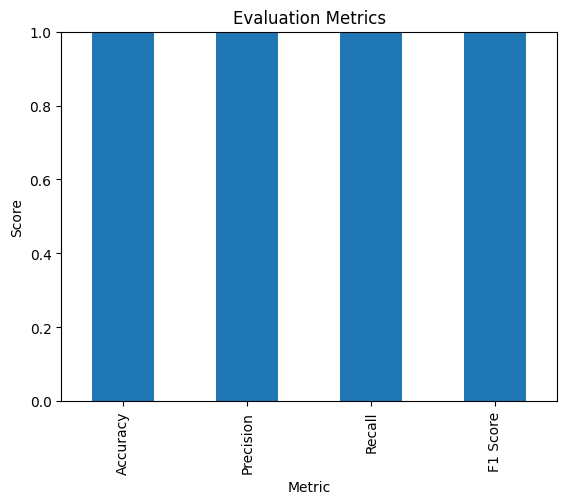

In [ ]:
# Necessary Imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Predicting the Validation Data
y_pred = best_model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Calculating Metrics
accuracy = accuracy_score(y_val, y_pred_classes)
precision = precision_score(y_val, y_pred_classes)
recall = recall_score(y_val, y_pred_classes)
f1 = f1_score(y_val, y_pred_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Inverted Confusion Matrix
cm_inverted = np.flip(cm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_inverted, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Inverted Confusion Matrix')
plt.show()

# Metrics in Table Format
import pandas as pd

metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Score": [accuracy, precision, recall, f1]
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

# Plotting Metrics
metrics_df.plot(kind='bar', x='Metric', y='Score', legend=False)
plt.ylim(0, 1)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.show()


In [ ]:
def classify_video(video_path, model, image_size=(64, 64), num_frames=10):
    # Extract frames from the video
    frames = extract_video_frames(video_path, image_size, num_frames)

    # Preprocess the frames
    preprocessed_frames = preprocess_frames(frames, image_size)

    # Perform prediction
    predictions = model.predict(preprocessed_frames)

    # Calculate average prediction score
    avg_prediction = np.mean(predictions)

    # Determine the class based on the prediction score
    threshold = 0.5  # Adjust this threshold as needed
    if avg_prediction >= threshold:
        return "Fake"
    else:
        return "Real"

# Example usage
video_path_to_classify = ""
classification_result = classify_video(video_path_to_classify, best_model)
print(f"The video is classified as: {classification_result}")


In [ ]:
def extract_video_frames(video_path, image_size, num_frames=10):
    video_capture = cv2.VideoCapture(video_path)
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for frame_num in range(min(frame_count, num_frames)):
        ret, frame = video_capture.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, image_size)
        frames.append(frame)
    return frames

def preprocess_frames(frames, image_size):
    frames_array = np.array(frames)
    frames_array = frames_array.astype('float32') / 255.0
    frames_array = frames_array.reshape((-1, image_size[0], image_size[1], 3))
    return frames_array

def predict_video(video_path, discriminator, image_size=(64, 64), num_frames=10):
    # Extract frames from the video
    frames = extract_video_frames(video_path, image_size, num_frames)

    # Preprocess the frames
    preprocessed_frames = preprocess_frames(frames, image_size)

    # Make predictions
    predictions = discriminator.predict(preprocessed_frames)

    # Average the predictions
    avg_prediction = np.mean(predictions)

    # Return binary classification
    return 'Real' if avg_prediction > 0.5 else 'Fake'

# Load the trained discriminator model
discriminator = load_model('/kaggle/working/best_model.h5')

# Path to the new video
new_video_path = 'path_to_new_video.mp4'

# Predict whether the video is real or fake
result = predict_video(new_video_path, discriminator)
print(f"The video is {result}")
